# Challenge: Vanilla Logistic Regression, Ridge Logistic Regression, Lasso Logistic Regression
Data clean up is similar to Unit 2, 4.4 Challenge where the data for this scenario is based on Florida.

In [1]:
import math
import warnings
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:3f}'.format

# Suppress warnings
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

# Bring in data
df = pd.read_csv("table_8_offenses_known_to_law_enforcement_florida_by_city_2013.csv")
# Pick the fourth row as the header
df.columns = df.iloc[3]
# Rename column headers to make it easier to work with
df.columns = ['city', 'population', 'violent', 'murder', 'rape_1', 'rape_2', 'robbery', 'assault', 'property', 'burglary', 'larceny', 'motor', 'arson', 'empty']
# Remove the any lines that are empty in Population column.
df.dropna(subset=['population'], inplace=True)
# Remove another line filled with wrong data
df.drop(df.index[0], inplace=True)
# Remove NaN values
df = df.fillna(0)

df.head()

,city,population,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson,empty
4,Alachua,"9,338",36,0,2,0,2,32,166,40,120,6,1,0.000000
5,Altamonte Springs,"42,040",150,0,8,0,37,105,"1,564",300,"1,180",84,3,0.000000
6,Altha,536,1,0,0,0,0,1,3,3,0,0,0,0.000000
7,Apalachicola,"2,269",1,0,0,0,0,1,35,8,27,0,0,0.000000
8,Apopka,"45,397",178,1,11,0,57,109,"1,527",231,"1,202",94,6,0.000000


In [2]:
# Remove columns that will not be added to the equation.
df = df.drop(columns=['city', 'population', 'empty'])
# Make definition to remove commas from strings
def replace(column):
    df[column] = df[column].str.replace(',', '')

# Convert type to integers
replace('violent')
replace('murder')
replace('rape_1')
#replace('rape_2')
replace('robbery')
replace('assault')
replace('property')
replace('burglary')
replace('larceny')
replace('motor')

df.head()

,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson
4,36,0,2,0,2,32,166,40,120,6,1
5,150,0,8,0,37,105,1564,300,1180,84,3
6,1,0,0,0,0,1,3,3,0,0,0
7,1,0,0,0,0,1,35,8,27,0,0
8,178,1,11,0,57,109,1527,231,1202,94,6


In [3]:
# We notice that the last three cells showed some serious outliers
df = df.sort_values('property')
df.tail(10)

,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson
142,172,0,8,0,31,133,952,239,680,33,2
251,139,2,9,0,18,110,960,222,717,21,2
183,108,0,26,0,15,67,964,264,687,13,1
76,1456,13,73,0,701,669,9650,2654,6429,567,30
70,15,1,0,0,7,7,97,65,23,9,0
227,340,6,9,0,59,266,974,326,560,88,4
163,919,4,53,0,377,485,9751,950,8425,376,6
87,3,0,0,0,0,3,98,16,80,2,1
229,116,0,12,0,39,65,987,119,832,36,2
66,9,0,0,0,0,9,NaN,13,NaN,1,0


In [4]:
# The NaN values are hard to replace and causes problems, remove this one line
df.drop(df.index[-1:], inplace=True)
df.tail(10)

,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson
108,10,0,1,0,0,9,95,14,79,2,0
142,172,0,8,0,31,133,952,239,680,33,2
251,139,2,9,0,18,110,960,222,717,21,2
183,108,0,26,0,15,67,964,264,687,13,1
76,1456,13,73,0,701,669,9650,2654,6429,567,30
70,15,1,0,0,7,7,97,65,23,9,0
227,340,6,9,0,59,266,974,326,560,88,4
163,919,4,53,0,377,485,9751,950,8425,376,6
87,3,0,0,0,0,3,98,16,80,2,1
229,116,0,12,0,39,65,987,119,832,36,2


In [5]:
# https://stackoverflow.com/questions/41985063/cannot-convert-nan-to-int-but-there-are-no-nans

# Convert to integer
df.violent = df.violent.astype(int)
df.murder = df.murder.astype(int)
df.rape_1 = df.rape_1.astype(int)
df.rape_2 = df.rape_2.astype(int)
df.robbery = df.robbery.astype(int)
df.assault = df.assault.astype(int)
df.property = df.property.astype(int)
#df['property'].fillna(0).astype(int) # Fix the other NaN values issue
df.burglary = df.burglary.astype(int)
df.larceny = df.larceny.astype(int)
#df['larceny'].fillna(0).astype(int) # Fix the other NaN values issue
df.motor = df.motor.astype(int)
df.arson = df.arson.astype(int)

df.tail(20)

,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson
42,84,0,5,0,11,68,879,165,667,47,0
74,16,0,2,0,3,11,88,18,63,7,0
67,30,1,1,0,2,26,88,29,46,13,0
261,2097,28,78,0,580,1411,8823,1950,6320,553,81
72,8,0,0,0,1,7,89,21,62,6,0
112,113,0,21,0,24,68,890,115,735,40,6
240,0,0,0,0,0,0,9,3,4,2,0
243,93,1,2,0,40,50,902,149,734,19,0
258,68,0,3,0,16,49,930,58,813,59,2
185,19,0,1,0,0,18,94,33,58,3,0


In [6]:
df.describe()

,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,183.837370,1.989619,11.754325,0.000000,54.394464,115.698962,1243.186851,264.487889,907.449827,71.249135,3.335640
std,511.996288,7.572558,33.088347,0.000000,178.014425,306.926943,2919.598035,617.407140,2135.688251,191.759924,10.219202
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,0.000000,1.000000,6.000000,87.000000,20.000000,58.000000,4.000000,0.000000
50%,45.000000,0.000000,3.000000,0.000000,7.000000,31.000000,380.000000,75.000000,268.000000,14.000000,0.000000
75%,143.000000,1.000000,10.000000,0.000000,36.000000,99.000000,1238.000000,259.000000,882.000000,57.000000,3.000000
max,5246.000000,93.000000,452.000000,0.000000,2216.000000,3277.000000,33007.000000,7069.000000,24361.000000,1914.000000,97.000000


In [7]:
df.dtypes

violent     int32
murder      int32
rape_1      int32
rape_2      int32
robbery     int32
assault     int32
property    int32
burglary    int32
larceny     int32
motor       int32
arson       int32
dtype: object

In [8]:
df.var() # Return unbiased variance over requested axis

violent     262140.199154
murder          57.343642
rape_1        1094.838740
rape_2           0.000000
robbery      31689.135525
assault      94204.148645
property   8524052.687188
burglary    381191.577110
larceny    4561164.303898
motor        36771.868272
arson          104.432093
dtype: float64

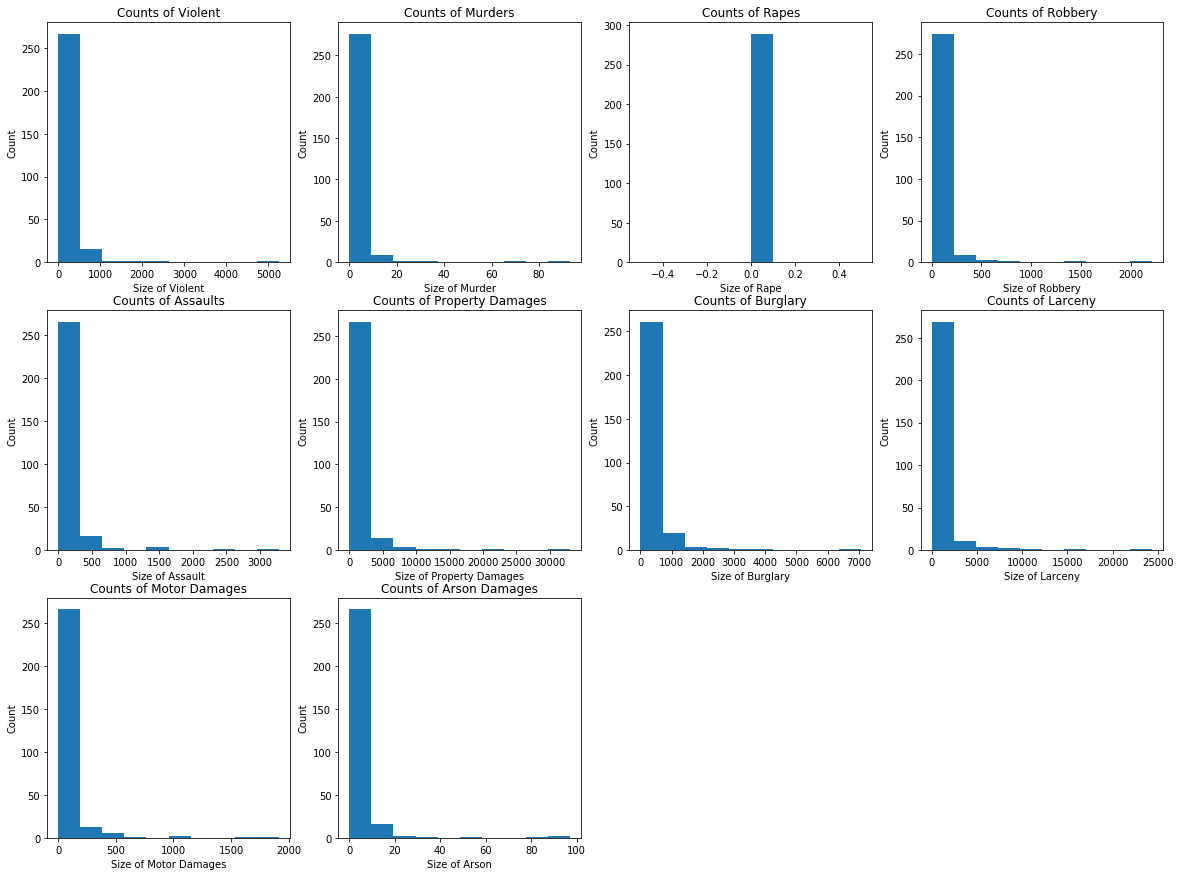

In [9]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

In [10]:
# Check for outliers and remove extreme ones
# Property has a few in the 10 thousands, removed
df = df.sort_values('property')
df.drop(df.index[-4:], inplace=True)
df.tail(10)

,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson
282,701,15,29,0,281,376,4863,1024,3453,386,21
81,806,6,62,0,155,583,4986,742,4000,244,13
218,819,7,64,0,273,475,5129,1220,3580,329,13
130,460,7,52,0,143,258,5410,1130,4082,198,4
99,720,16,63,0,253,388,6550,1500,4478,572,6
93,774,13,41,0,231,489,6550,763,5079,708,12
259,1398,11,160,0,387,840,8116,2082,5594,440,7
261,2097,28,78,0,580,1411,8823,1950,6320,553,81
76,1456,13,73,0,701,669,9650,2654,6429,567,30
163,919,4,53,0,377,485,9751,950,8425,376,6


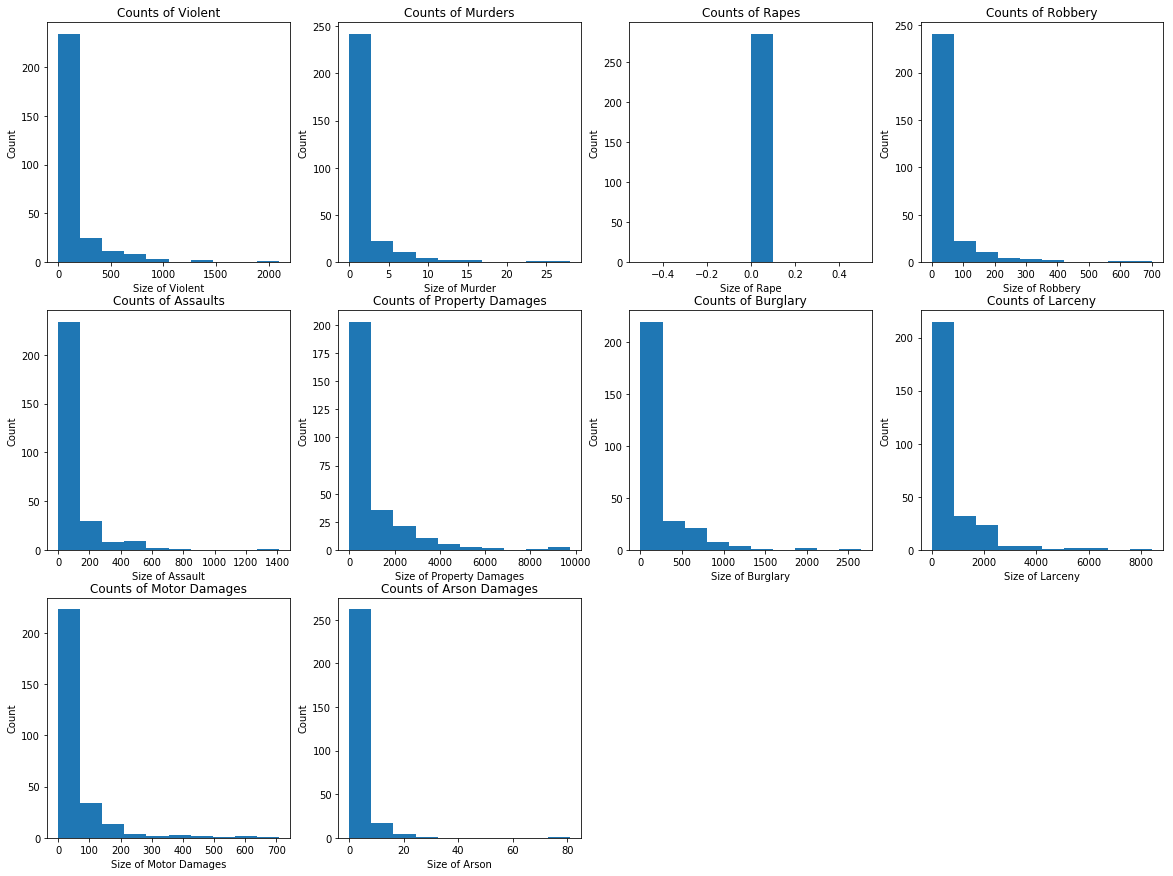

In [11]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

# Apply Vanilla Logistic Regression

In [12]:
# Select columns to turn into binary, leave murder column as continuous
df1 = df.copy()
df1['violent'][df1['violent'] > 0] = 1
#df1['murder'][df1['murder'] > 0] = 1
df1['rape_1'][df1['rape_1'] > 0] = 1
df1['rape_2'][df1['rape_2'] > 0] = 1
df1['robbery'][df1['robbery'] > 0] = 1
df1['assault'][df1['assault'] > 0] = 1
df1['property'][df1['property'] > 0] = 1
df1['burglary'][df1['burglary'] > 0] = 1
df1['larceny'][df1['larceny'] > 0] = 1
df1['motor'][df1['motor'] > 0] = 1
df1['arson'][df1['arson'] > 0] = 1
df1.tail()

,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson
93,1,13,1,0,1,1,1,1,1,1,1
259,1,11,1,0,1,1,1,1,1,1,1
261,1,28,1,0,1,1,1,1,1,1,1
76,1,13,1,0,1,1,1,1,1,1,1
163,1,4,1,0,1,1,1,1,1,1,1


(285,)
(285,)


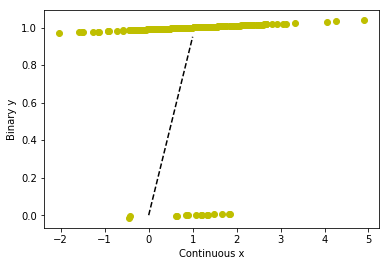

In [13]:
# Continuous predictor using murder
x = df1['property']

# Binary outcome using violent
bin_y = df1['violent']

# Calculate linear regression for x and bin_y.
fit = np.polyfit(x,bin_y,1)

# Work as a function to return the predicted value of y.
fit_fn = np.poly1d(fit)

# Add a little 'noise' to the data for graphing purposes.
jitter = np.random.randn(285)

print(x.shape)
print(bin_y.shape)

# Display our results.
plt.plot(x + jitter, bin_y + jitter / 100, 'yo', x, fit_fn(x), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Binary y')
plt.show()

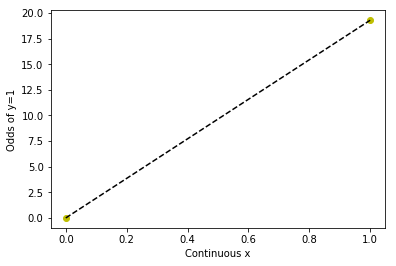

In [14]:
# Unique values in x.
xvals = x.unique()

# Calculate and store the odds.
yodds = []
for xi in xvals: 
    y1_ct = bin_y[x == xi].sum()  # The number of trials y = 1.
    y0_ct = len(bin_y[x == xi]) - y1_ct  # The number of trials y = 0.
    yodds.append(y1_ct / y0_ct)  # Odds of getting y = 1 for xi.
    
# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, yodds, 1)

# Work as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display our work.
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Odds of y=1')
plt.show()

[0.0, 19.285714285714285]
[      -inf 2.95936463]


C:\Users\nyejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


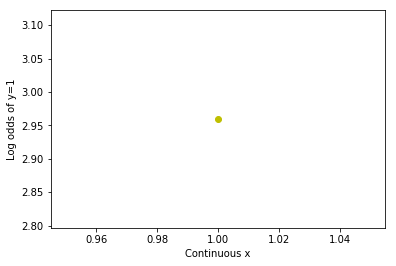

In [15]:
# Natural log of the odds.
ln_yodds = np.log(yodds)

# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, ln_yodds, 1)

# Works as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display.
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Log odds of y=1')

print(yodds)
print(ln_yodds)

plt.show()

# Apply Ridge Regression

In [16]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
Y = df['property']
X = df.drop(['property'],axis=1)
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Ridge Regression
print('\nR-squared simple model:')
print(regr.score(X, Y))


Coefficients: 
 [-3.76001518e-14 -1.51285186e-13  3.82663470e-14 -1.11022302e-16
  3.72158701e-14  3.85241495e-14  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -3.18014713e-15]

Intercept: 
 -2.2737367544323206e-13

R-squared:
1.0

R-squared simple model:
1.0


In [17]:
#data = df1[['rape_2', 'property', 'burglary', 'larceny', 'motor', 'arson']]
#target = df1['murder']

data = df.drop(['property'],axis=1)
target = df['property']

## Holdout Groups is commonly starting at 30% of data, but 1% to 50% is okay.
print(data.shape)
print(target.shape)
#print(data)
#print(target)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

# Test using the classifier, not the bernoulli this time
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)
print(clf)

# Cross Validation
# Estimate the accuracy of a linear kernel support vector machine on the dataset by splitting the data,
# fitting a model and computing the score 4 consecutive times (with different splits each time).
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, data, target, cv=4)
print(scores)

# Mean scores and 95% confidence intervals
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

(285, 10)
(285,)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


C:\Users\nyejy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


[0.04724409 0.2        0.         0.        ]
Accuracy: 0.06 (+/- 0.16)


In [18]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)
print(ridgeregr.score(X_train, y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

0.9999999999982374
0.00012617588489273473


# Apply Lasso Regression

In [19]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, y_train)
print('R² for the model with few features:')
print(lass.score(X_train, y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

R² for the model with few features:
0.9999999964852035

Parameter estimates for the model with few features:
[ 0.00164845  0.          0.          0.          0.0016284  -0.00162026
  0.99932701  1.00009772  0.9981079  -0.          0.02147474]


In [20]:
print(lass.score(X_test, y_test))

0.999999991302397
